# Машинне навчання
# Лабораторна робота №8
# Вишотравка Діана СА-33
## Варіант 4

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import re
from textblob import TextBlob
from tqdm import trange
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
import scipy.stats as sp
from flaml import AutoML
from eds import *

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(rc={'figure.figsize': (20 , 15 ),
                  "lines.linewidth": 2.5}, font_scale=1.5)
palette = ['#2f6142','#69e0ab', '#80e0dc', '#0ca69f', '#046091', '#877ff0', '#6a4280', '#f5a6e1', '#7a1160']
sns.set_palette(palette)

In [49]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [99]:
def conf_matrix(y_true: pd.Series | np.ndarray, y_pred: pd.Series | np.ndarray, **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(40, 20))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            colorbar=False, ax=axes[0], values_format="d", **kwargs)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize= 'true',
                                            colorbar=False, ax = axes[1], values_format=".2f", **kwargs)
    axes[1].set_title('Normalized by recall')
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize= 'pred',
                                            colorbar=False, ax = axes[2], values_format=".2f", **kwargs)
    axes[2].set_title('Normalized by precision')
    for i in axes:
        i.tick_params(axis='x', rotation=90, labelsize=15)
    for i in range(0,3):
        axes[i].grid(False)
    plt.rcParams.update({'font.size': 24})
    plt.tight_layout()
    return fig, axes

In [51]:
def report(y_true: pd.Series | np.ndarray, y_pred: pd.Series | np.ndarray) -> dict[str, float]:
    return ({
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='micro'),
        'Recall': recall_score(y_true, y_pred, average='micro'),
        'F-score': f1_score(y_true, y_pred, average='micro'),
    })

In [94]:
def visualize(df, **kwargs):
    columns = df.columns
    num_rows = (len(columns))
    fig, axes = plt.subplots(nrows=num_rows, figsize=(40, num_rows * 8))
    for i, column in enumerate(columns):
        row = i
        sns.histplot(df, x =column, ax=axes[row])
        for k in range(len(axes[row].containers)):
            axes[row].bar_label(axes[row].containers[k], fontsize=13)
    fig.tight_layout()
    return fig, axes

In [53]:
df_train = pd.read_csv('train.txt', sep=';', names=['text', 'emotion'])
df_val = pd.read_csv('val.txt', sep=';', names=['text', 'emotion'])
df_test = pd.read_csv('test.txt', sep=';', names=['text', 'emotion'])

## EDA

In [54]:
df_train

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [55]:
df_train.shape

(16000, 2)

In [56]:
print(f'Number of duplicate entries: {df_train.duplicated().sum()}')

Number of duplicate entries: 1


In [57]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)
df_val.drop_duplicates(inplace=True)

In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15999 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     15999 non-null  object
 1   emotion  15999 non-null  object
dtypes: object(2)
memory usage: 375.0+ KB


In [59]:
df_train.describe()

,text,emotion
count,15999,15999
unique,15969,6
top,i feel on the verge of tears from weariness i ...,joy
freq,2,5361


### Feature engineering

In [60]:
df_train['length'] = df_train['text'].str.len()

In [61]:
def word_count(text):
    line = text.split()
    return len(line)

In [62]:
df_train['word_count'] = df_train['text'].apply(word_count)

In [63]:
df_train['mean_word_length'] = df_train['text'].map(lambda text: np.mean([len(word) for word in text.split()]))

In [64]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    return sentiment

In [65]:
df_train['sent_lvl'] = df_train['text'].apply(analyze_sentiment)

In [66]:
df_train

,text,emotion,length,word_count,mean_word_length,sent_lvl
0,i didnt feel humiliated,sadness,23,4,5.000000,0.000000
1,i can go from feeling so hopeless to so damned...,sadness,108,21,4.190476,0.000000
2,im grabbing a minute to post i feel greedy wrong,anger,48,10,3.900000,-0.500000
3,i am ever feeling nostalgic about the fireplac...,love,92,18,4.166667,-0.500000
4,i am feeling grouchy,anger,20,4,4.250000,0.000000
...,...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,24,3.250000,0.000000
15996,i am now turning and i feel pathetic that i am...,sadness,102,20,4.150000,-1.000000
15997,i feel strong and good overall,joy,30,6,4.166667,0.377778
15998,i feel like this was such a rude comment and i...,anger,59,14,3.285714,0.066667


In [67]:
df_train.columns

Index(['text', 'emotion', 'length', 'word_count', 'mean_word_length',
       'sent_lvl'],
      dtype='object')

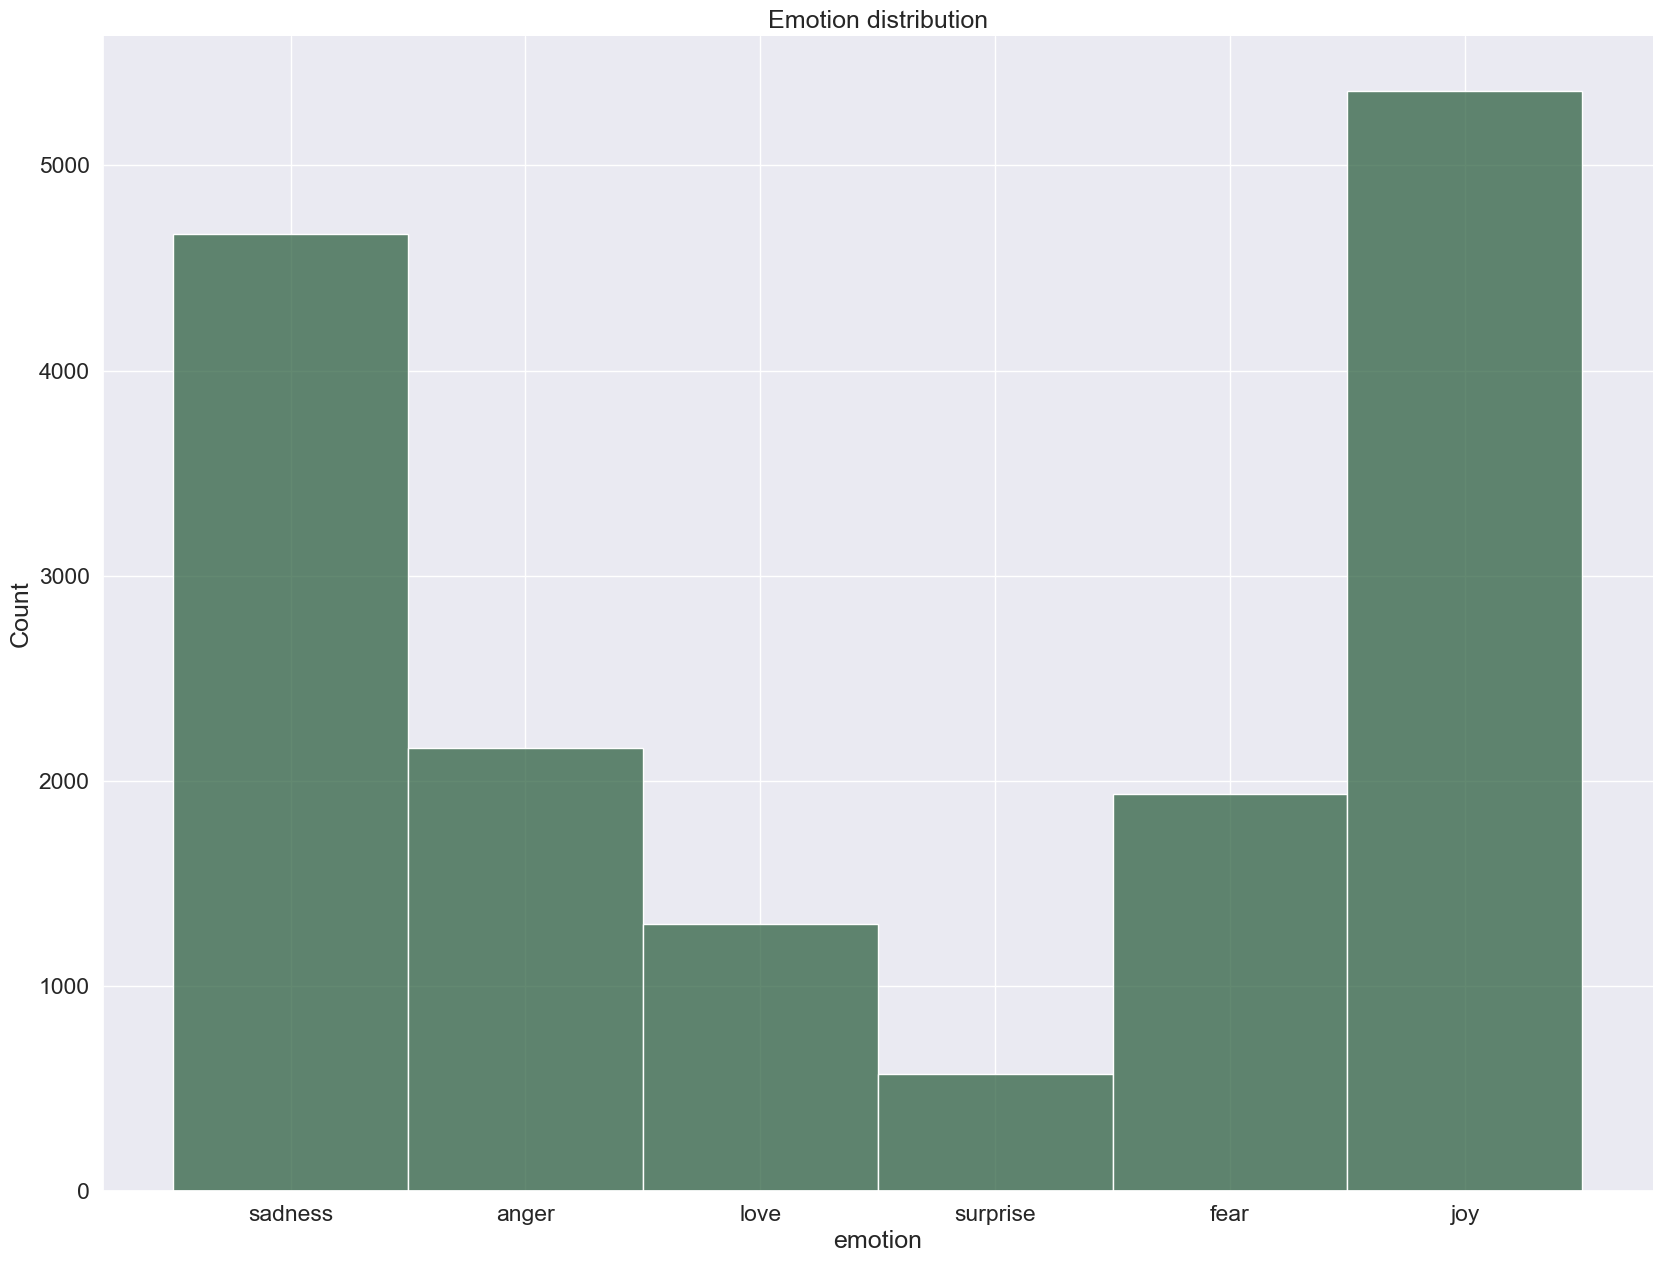

In [68]:
sns.histplot(df_train, x='emotion').set(title='Emotion distribution')
sns.despine()
plt.show()

(<Figure size 4000x3200 with 4 Axes>,
 array([<Axes: xlabel='length', ylabel='Count'>,
        <Axes: xlabel='word_count', ylabel='Count'>,
        <Axes: xlabel='mean_word_length', ylabel='Count'>,
        <Axes: xlabel='sent_lvl', ylabel='Count'>], dtype=object))

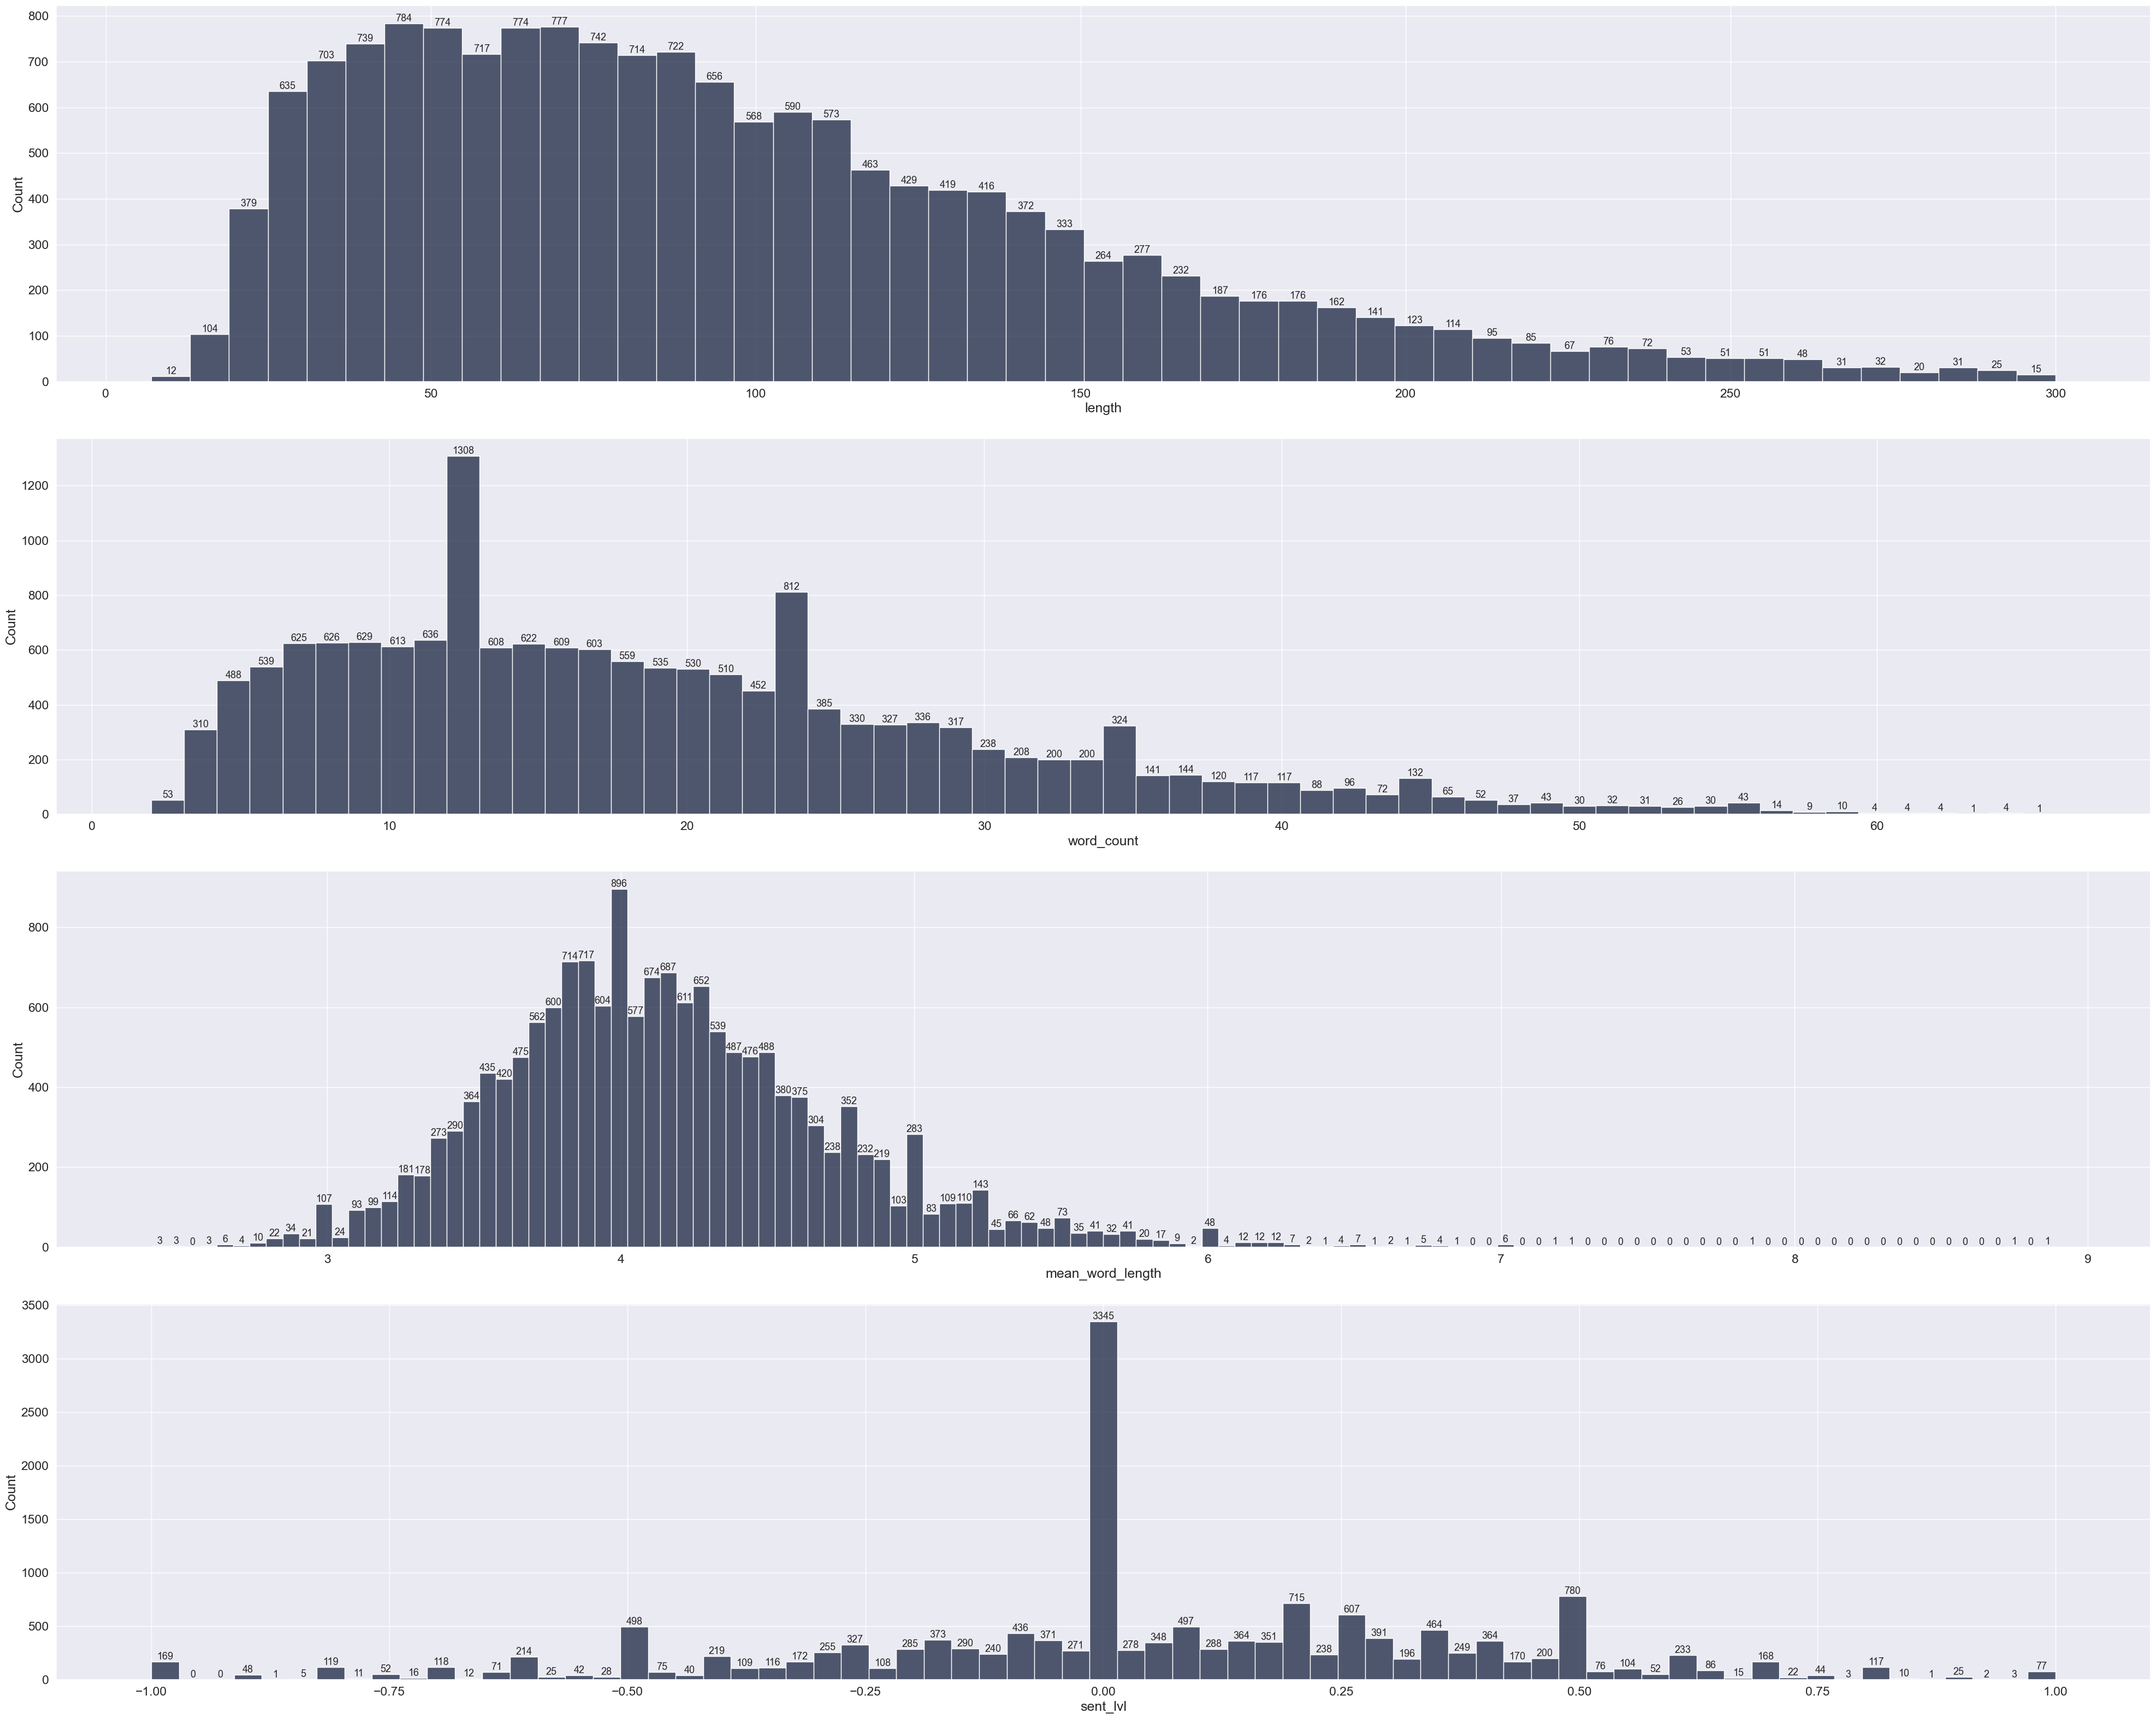

In [95]:
visualize(df_train[['length', 'word_count', 'mean_word_length',
       'sent_lvl']])

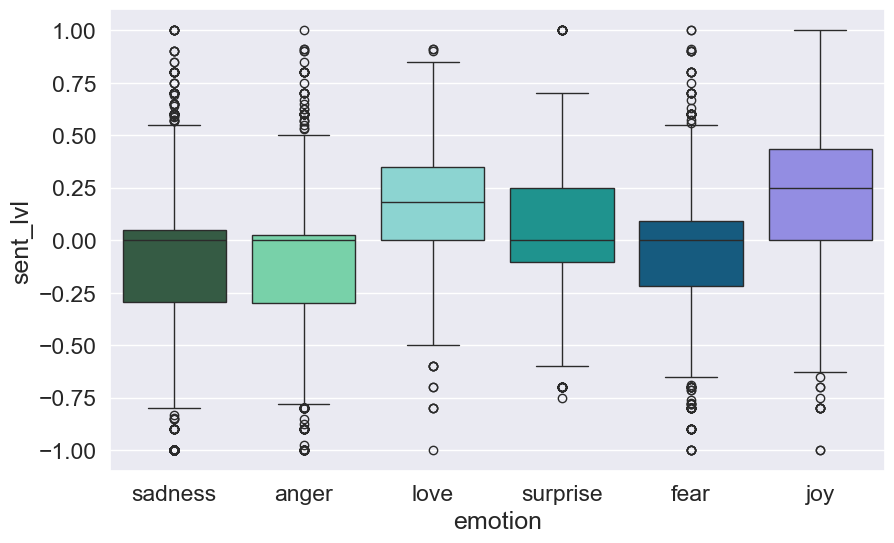

In [70]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y='sent_lvl', data=df_train, hue='emotion' )
plt.show()

In [71]:
def clean(review):
    
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    
    return review

In [72]:
df_train['text'] = df_train['text'].apply(clean)
df_train

,text,emotion,length,word_count,mean_word_length,sent_lvl
0,didnt feel humiliated,sadness,23,4,5.000000,0.000000
1,go feeling hopeless damned hopeful around some...,sadness,108,21,4.190476,0.000000
2,im grabbing minute post feel greedy wrong,anger,48,10,3.900000,-0.500000
3,ever feeling nostalgic fireplace know still pr...,love,92,18,4.166667,-0.500000
4,feeling grouchy,anger,20,4,4.250000,0.000000
...,...,...,...,...,...,...
15995,brief time beanbag said anna feel like beaten,sadness,101,24,3.250000,0.000000
15996,turning feel pathetic still waiting tables sub...,sadness,102,20,4.150000,-1.000000
15997,feel strong good overall,joy,30,6,4.166667,0.377778
15998,feel like rude comment im glad,anger,59,14,3.285714,0.066667


In [73]:
def corpus(text):
    text_list = text.split()
    return text_list

In [75]:
df_train['words'] = df_train['text'].apply(corpus)

In [76]:
corpus = []
for i in trange(df_train.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df_train['words'].iloc[i]
len(corpus)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 15999/15999 [00:00<00:00, 32871.79it/s]


149640

In [77]:
mostCommon = Counter(corpus).most_common(10)
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

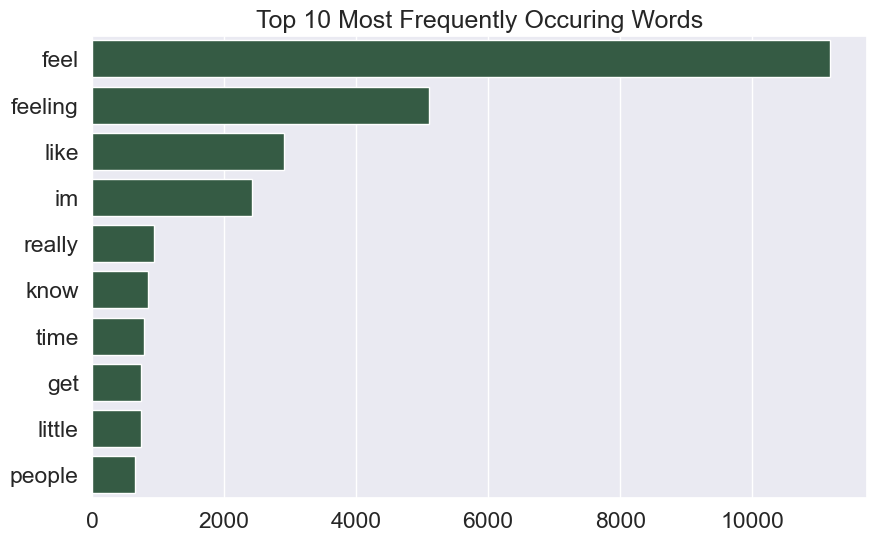

In [78]:
plt.figure(figsize=(10, 6))
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

In [79]:
df_train.drop('words', axis=1, inplace=True)

## Pipeline

In [80]:
class SentimentAnalyzer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sentiments = []
        for text in X:
            blob = TextBlob(text)
            sentiment_score = blob.sentiment.polarity
            sentiments.append(sentiment_score)
        return pd.DataFrame(sentiments, columns=['sent_lvl'])

In [81]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_texts = []
        for text in X:
            tokens = word_tokenize(text.lower())
            filtered_tokens = [token for token in tokens if token not in self.stop_words]
            lemmatized_tokens = [self.lemmatizer.lemmatize(token) for token in filtered_tokens]
            preprocessed_texts.append(' '.join(lemmatized_tokens))
        return preprocessed_texts

In [82]:
pip_count_vec = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('features', FeatureUnion([
        ('count', CountVectorizer(max_features=5000)),
        ('sentiment_analysis', SentimentAnalyzer())
    ]))
])

## Count Vectorizer

In [83]:
x_train_processed = pip_count_vec.fit_transform(df_train['text'])

In [84]:
clf = AutoML()
clf.fit(x_train_processed, df_train['emotion'], X_val=pip_count_vec.transform(df_val['text']), y_val=df_val['emotion'], task='classification', metric='micro_f1', time_budget=100, estimator_list=['lgbm'],
n_jobs=8, early_stop=True)

[flaml.automl.logger: 05-21 10:48:54] {1680} INFO - task = classification
[flaml.automl.logger: 05-21 10:48:54] {1688} INFO - Data split method: stratified
[flaml.automl.logger: 05-21 10:48:54] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 05-21 10:48:54] {1789} INFO - Minimizing error metric: 1-micro_f1
[flaml.automl.logger: 05-21 10:48:54] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 05-21 10:48:54] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-21 10:48:55] {2345} INFO - Estimated sufficient time budget=9873s. Estimated necessary time budget=10s.
[flaml.automl.logger: 05-21 10:48:55] {2392} INFO -  at 1.2s,	estimator lgbm's best error=0.5360,	best estimator lgbm's best error=0.5360
[flaml.automl.logger: 05-21 10:48:55] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-21 10:48:56] {2392} INFO -  at 1.8s,	estimator lgbm's best error=0.5360,	best estimator lgbm's best error=0.5360
[fla

In [85]:
clf.best_config

{'n_estimators': 88,
 'num_leaves': 74,
 'min_child_samples': 4,
 'learning_rate': 0.09348689572544734,
 'log_max_bin': 7,
 'colsample_bytree': 0.5967846088487322,
 'reg_alpha': 0.006958608037974516,
 'reg_lambda': 0.001895876878997586}

In [86]:
print(classification_report(df_val['emotion'], clf.predict(pip_count_vec.transform(df_val['text']))))

              precision    recall  f1-score   support

       anger       0.90      0.89      0.89       275
        fear       0.84      0.88      0.86       212
         joy       0.92      0.94      0.93       704
        love       0.87      0.83      0.85       178
     sadness       0.94      0.95      0.94       550
    surprise       0.94      0.72      0.81        81

    accuracy                           0.91      2000
   macro avg       0.90      0.87      0.88      2000
weighted avg       0.91      0.91      0.91      2000



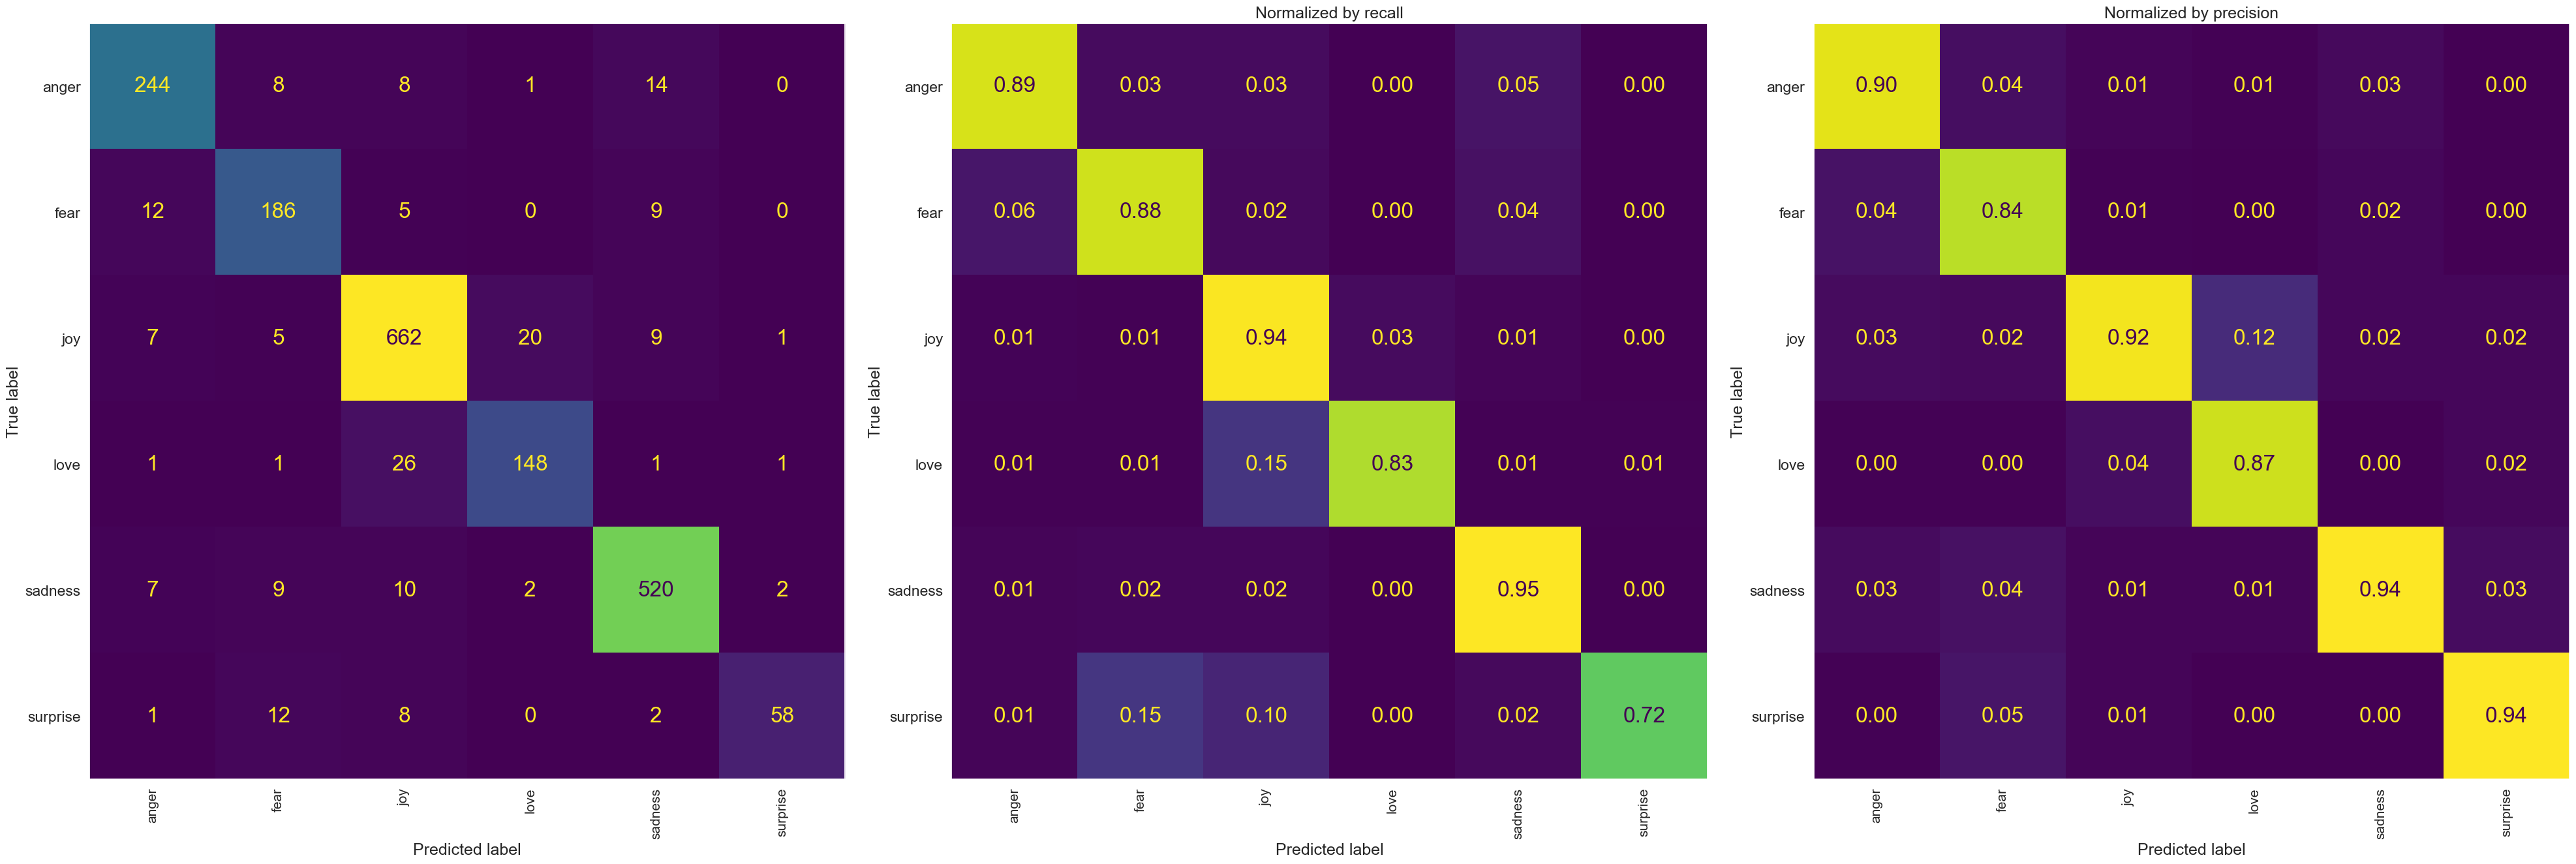

In [100]:
sns.set_palette("cubehelix")
conf_matrix(df_val['emotion'], clf.predict(pip_count_vec.transform(df_val['text'])))
plt.show()

## TfidfVectorizer

### Pipeline

In [88]:
pip_tfidf = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('sentiment_analysis', SentimentAnalyzer())
    ]))
])

In [89]:
clf_tfidf = AutoML()
clf_tfidf.fit(pip_tfidf.fit_transform(df_train['text']), df_train['emotion'], X_val=pip_tfidf.transform(df_val['text']), y_val=df_val['emotion'], task='classification', metric='micro_f1', time_budget=120, estimator_list=['lgbm'],
n_jobs=8, early_stop=True)

[flaml.automl.logger: 05-21 10:50:51] {1680} INFO - task = classification
[flaml.automl.logger: 05-21 10:50:51] {1688} INFO - Data split method: stratified
[flaml.automl.logger: 05-21 10:50:51] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 05-21 10:50:51] {1789} INFO - Minimizing error metric: 1-micro_f1
[flaml.automl.logger: 05-21 10:50:51] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 05-21 10:50:51] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-21 10:50:52] {2345} INFO - Estimated sufficient time budget=5056s. Estimated necessary time budget=5s.
[flaml.automl.logger: 05-21 10:50:52] {2392} INFO -  at 0.6s,	estimator lgbm's best error=0.5360,	best estimator lgbm's best error=0.5360
[flaml.automl.logger: 05-21 10:50:52] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-21 10:50:52] {2392} INFO -  at 1.0s,	estimator lgbm's best error=0.5360,	best estimator lgbm's best error=0.5360
[flam

In [90]:
clf_tfidf.best_config

{'n_estimators': 76,
 'num_leaves': 74,
 'min_child_samples': 7,
 'learning_rate': 0.08942415810668894,
 'log_max_bin': 9,
 'colsample_bytree': 0.6948775943662204,
 'reg_alpha': 0.006958608037974516,
 'reg_lambda': 0.029797596459370874}

In [91]:
print(classification_report(df_val['emotion'], clf_tfidf.predict(pip_count_vec.transform(df_val['text']))))

              precision    recall  f1-score   support

       anger       0.90      0.89      0.90       275
        fear       0.87      0.85      0.86       212
         joy       0.92      0.93      0.93       704
        love       0.85      0.84      0.85       178
     sadness       0.92      0.94      0.93       550
    surprise       0.88      0.84      0.86        81

    accuracy                           0.91      2000
   macro avg       0.89      0.88      0.89      2000
weighted avg       0.91      0.91      0.91      2000



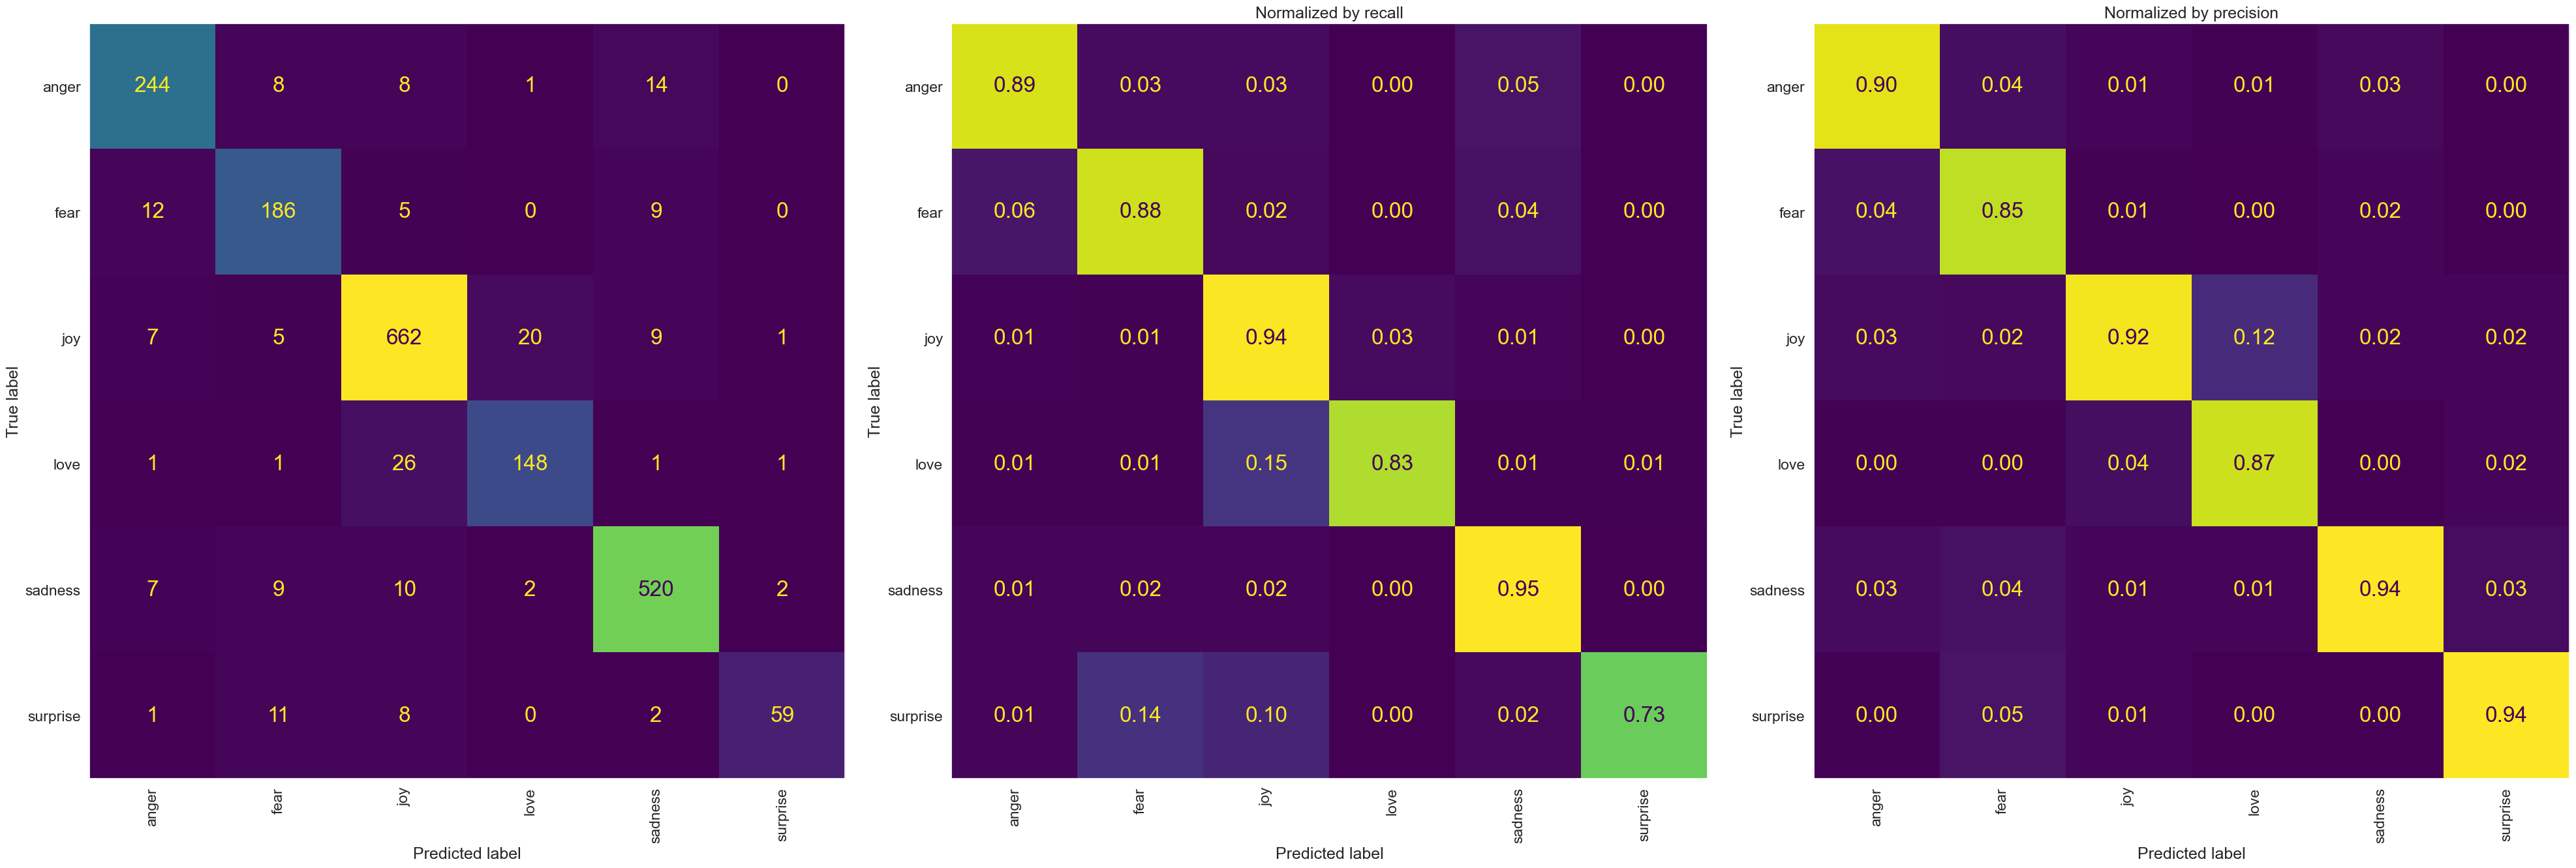

In [98]:
conf_matrix(df_val['emotion'], clf.predict(pip_tfidf.transform(df_val['text'])))
plt.show()

## Results

In [93]:
pd.concat((
    pd.DataFrame(report(df_test['emotion'], clf.predict(pip_count_vec.transform(df_test['text']))), 
                 index=['Count Vectorizer']),
    pd.DataFrame((report(df_test['emotion'], clf_tfidf.predict(pip_tfidf.transform(df_test['text'])))),
                 index=['TfidfVectorizer']))).T

,Count Vectorizer,TfidfVectorizer
Accuracy,0.8985,0.9005
Precision,0.8985,0.9005
Recall,0.8985,0.9005
F-score,0.8985,0.9005
